<a href="https://colab.research.google.com/github/jc-brunet/Divers-Cpp/blob/main/Object_Detection_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for Computer Vision: Object Detection

Modified by: Alexandre Bruckert / Nantes University

date: 2024


## Introduction

In this lab, we will we will work with the PASCAL VOC 2012 dataset, which is widely used for object detection, classification, and segmentation tasks. The dataset contains images from 20 object categories, including people, animals, and vehicles, with annotations for both object detection (bounding boxes) and segmentation (masks).

Our goal in this project will be to train a model for object detection, where we detect the objects and draw bounding boxes around them.

We will begin by downloading the dataset, loading the data, and visualizing some sample images with their ground truth bounding boxes.

In [2]:
!pip install tqdm
!pip install matplotlib

In [3]:
# Import necessary libraries
import os
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, Subset
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
from torchvision.datasets import VOCDetection
import torchvision.models.detection as detection


import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET


from tqdm import tqdm  # For progress bar

In [5]:
# Specify where you want to store the dataset
dataset_root = '/data_VOC'  # You can specify a different directory if needed

# Download the PASCAL VOC 2012 trainval dataset
train_dataset = torchvision.datasets.VOCDetection(
    root=dataset_root,
    year='2012',            # Download the 2012 version
    image_set='train',    # Download the trainval split
    download=True,           # Set to False if the dataset is already present
    transform=transforms.ToTensor()  # Transform to Tensor
)

val_dataset = torchvision.datasets.VOCDetection(
    root=dataset_root,
    year='2012',
    image_set='val',
    download= True,           # Set to False if the dataset is already present
    transform=transforms.ToTensor()  # Transform to Tensor
)


print(f"Training Dataset size: {len(train_dataset)} images")
print(f"Validation Dataset size: {len(val_dataset)} images")

100%|██████████| 2.00G/2.00G [01:36<00:00, 20.7MB/s]


Extracting /data_VOC/VOCtrainval_11-May-2012.tar to /data_VOC
Using downloaded and verified file: /data_VOC/VOCtrainval_11-May-2012.tar
Extracting /data_VOC/VOCtrainval_11-May-2012.tar to /data_VOC
Training Dataset size: 5717 images
Validation Dataset size: 5823 images


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Data Loading and Parsing Ground Truth Bounding Boxes

Now, we will write the code to parse the dataset, extract the images, and get the corresponding ground truth bounding boxes and labels. The dataset is in the form of a list of dictionaries, where each dictionary contains the image file path, size, and annotations for the objects in the image.

We will also apply a few transformations to the data : resizing to a fixed (300x300), and normalizing with regard to the Resnet50 backbone.

In [6]:
import matplotlib.image as mpimg

class PascalVOCDataset(Dataset):
    def __init__(self, root, image_set='train', transform=None):
        """
        Args:
            root (string): Root directory of the VOC dataset.
            image_set (string): 'train' or 'val' or 'trainval' or 'test'.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root = root
        self.image_set = image_set
        self.transform = transform

        # Define the image and annotation directories
        self.image_dir = os.path.join(self.root, 'VOC2012', 'JPEGImages')
        self.annotation_dir = os.path.join(self.root, 'VOC2012', 'Annotations')

        # Load the image set file
        with open(os.path.join(self.root, 'VOC2012', 'ImageSets', 'Main', f'{image_set}.txt')) as f:
            self.image_ids = f.read().strip().splitlines()

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]

        # Load the image
        img_path = os.path.join(self.image_dir, f'{img_id}.jpg')
        img = Image.open(img_path).convert("RGB")

        # Load the corresponding XML annotation
        annotation_path = os.path.join(self.annotation_dir, f'{img_id}.xml')
        target = self.parse_annotation(annotation_path)

        if self.transform:
            img = self.transform(img)

        return img, target

    def parse_annotation(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        boxes = []
        labels = []

        # Iterate through all objects in the annotation
        for obj in root.findall('object'):
            if obj.find('difficult').text == '0':  # Only consider non-difficult objects
                label = obj.find('name').text
                label = self.convert_label_to_id(label)  # Convert label to integer id
                bbox = obj.find('bndbox')
                boxes.append([
                    float(bbox.find('xmin').text),
                    float(bbox.find('ymin').text),
                    float(bbox.find('xmax').text),
                    float(bbox.find('ymax').text)
                ])
                labels.append(label)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        return {
            "boxes": boxes,
            "labels": labels
        }

    def convert_label_to_id(self, label):
        # Define a mapping from class names to IDs
        class_mapping = {
            'aeroplane': 1,
            'bicycle': 2,
            'bird': 3,
            'boat': 4,
            'bottle': 5,
            'bus': 6,
            'car': 7,
            'cat': 8,
            'chair': 9,
            'cow': 10,
            'diningtable': 11,
            'dog': 12,
            'horse': 13,
            'motorbike': 14,
            'person': 15,
            'pottedplant': 16,
            'sheep': 17,
            'sofa': 18,
            'train': 19,
            'tvmonitor': 20
        }
        return class_mapping.get(label, 0)  # Default to 0 if not found

# Define the transformation for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Create dataset instances
train_dataset = PascalVOCDataset(root='/data_VOC/VOCdevkit', image_set='train', transform=transform)
val_dataset = PascalVOCDataset(root='/data_VOC/VOCdevkit', image_set='val', transform=transform)

# Example of how to get a sample
img, target = train_dataset[0]
print("Image :", img)
print("Target:", target)

Image : tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.7922, 0.7961, 0.8000],
         [1.0000, 1.0000, 1.0000,  ..., 0.7961, 0.7961, 0.7922],
         [1.0000, 1.0000, 1.0000,  ..., 0.8078, 0.8039, 0.8039],
         ...,
         [0.8039, 0.7608, 0.8078,  ..., 0.5373, 0.4706, 0.4667],
         [0.7529, 0.7569, 0.7569,  ..., 0.4353, 0.4235, 0.4784],
         [0.6980, 0.7059, 0.7255,  ..., 0.3216, 0.2863, 0.3137]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.8039, 0.8078, 0.8118],
         [1.0000, 1.0000, 1.0000,  ..., 0.8078, 0.8078, 0.8039],
         [1.0000, 1.0000, 1.0000,  ..., 0.8196, 0.8157, 0.8157],
         ...,
         [0.7490, 0.7059, 0.7529,  ..., 0.5020, 0.4392, 0.4431],
         [0.6980, 0.7020, 0.7020,  ..., 0.4157, 0.4039, 0.4667],
         [0.6431, 0.6510, 0.6706,  ..., 0.3020, 0.2667, 0.3020]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.9725, 0.9765, 0.9804],
         [1.0000, 1.0000, 1.0000,  ..., 0.9765, 0.9765, 0.9725],
         [1.0000, 1.0000, 1.0000,  ..., 0.9882, 0.

### Visualizing function

Here are a few utility functions that will allow you to visualize predictions made by the model.

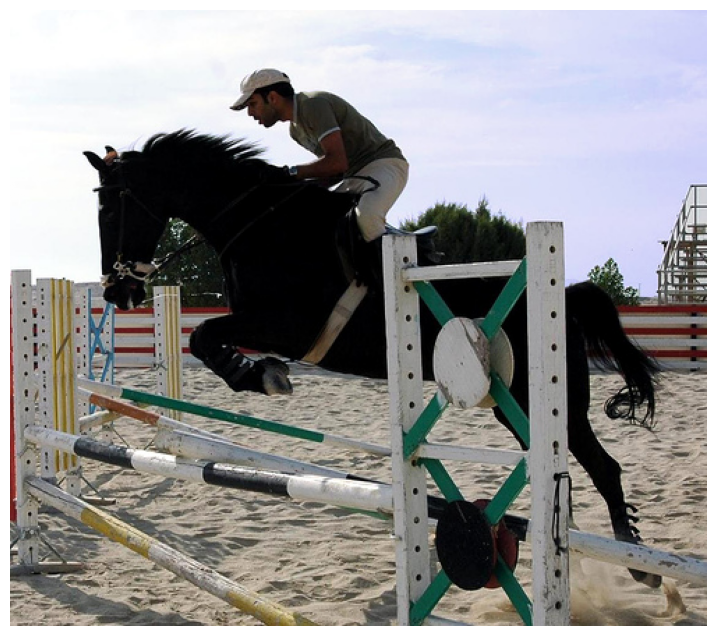

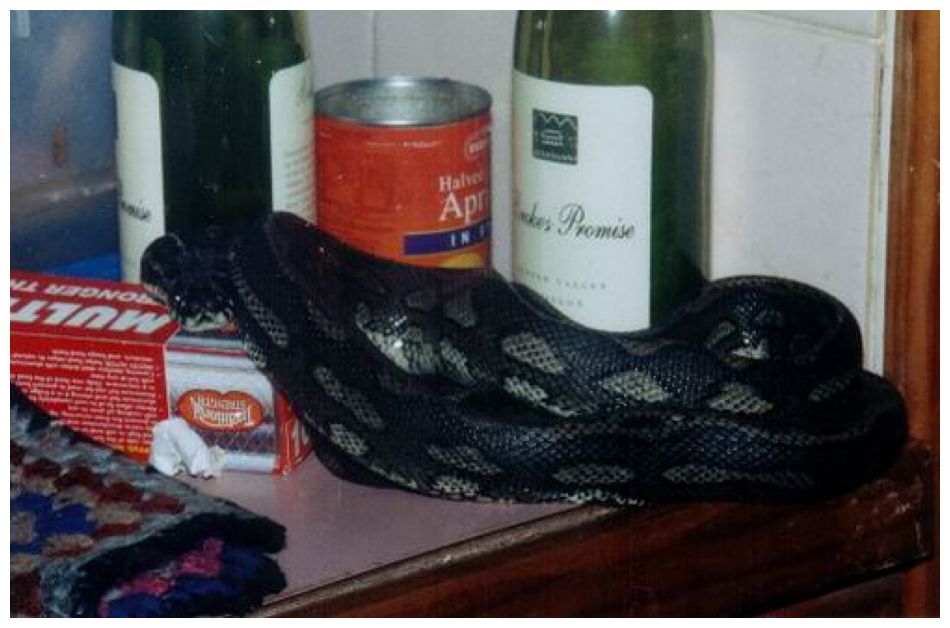

In [7]:
def load_image(image_path):
    """Load an image from file."""
    image = Image.open(image_path).convert("RGB")
    return image

def prepare_image(image, transform=None):
    """Prepare the image for model input."""
    if transform:
        image = transform(image)
    return image.unsqueeze(0)  # Add batch dimension

def visualize_predictions(image, boxes, labels, scores, threshold=0.4):
    """Visualize the bounding boxes and labels on the image."""
    plt.figure(figsize=(12, 8))
    plt.imshow(image.permute(1, 2, 0).numpy())

    # Filter out boxes and labels below the threshold
    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:
            x_min, y_min, x_max, y_max = box
            plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                                fill=False, edgecolor='red', linewidth=3))
            plt.text(x_min, y_min, f'{label.item()}: {score:.2f}', fontsize=12, color='red')

    plt.axis('off')
    plt.show()

def visualize_base_image(image):
    """Visualize the basic image."""
    plt.figure(figsize=(12, 8))
    plt.imshow(image.permute(1, 2, 0).numpy())

    plt.axis('off')
    plt.show()

for i in range(2):
    img, target=train_dataset[i]
    visualize_base_image(img)

QUESTION 1: We should be wary of overfitting, considering that we have a very small dataset compared to the size of the network. There is a big data imbalance as objects of class 15 (person) are much more numerous than the others (31% of total), while classes 10 (cow) and 18 (sofa) are barely 2% of the total each (equidistribution should be 100/20=5%).
We should be careful that the model does not determine that deciding the class 'person' everytime is sufficient - thus we must not use too big a learning rate, and use too many epochs

In [8]:
classes_count=np.zeros(21)
nb_objects_count={}


train_dataset_size=len(train_dataset)

for i in range(train_dataset_size):
   img,target= train_dataset[i]
   nb_objects=len(train_dataset[i])
   if(nb_objects_count.get(nb_objects) is None):
      nb_objects_count[nb_objects]=1
   else: nb_objects_count[nb_objects]+=1
   for class_nb in target['labels']:
      classes_count[class_nb]+=1

In [9]:
print(classes_count)
print(classes_count/sum(classes_count))


[   0.  432.  353.  560.  426.  629.  292. 1013.  605. 1178.  290.  304.
  756.  350.  357. 4194.  484.  400.  281.  313.  392.]
[0.         0.0317437  0.02593872 0.04114924 0.03130281 0.04621941
 0.02145639 0.07443603 0.04445587 0.08656036 0.02130943 0.02233816
 0.05555147 0.02571827 0.02623264 0.30817841 0.0355647  0.02939231
 0.0206481  0.02299949 0.02880447]



### Training loop

Here, we will train our model. Be careful with the learning rate !

In [39]:


# Hyperparameters
num_epochs = 10
learning_rate =0.0005
batch_size = 4
val_size = 600  # Number of validation images
train_size = 1000  # Number of training images

#Training and validation loss arrays
train_loss_array=np.array([])
val_loss_array=np.array([])

# Create the original dataset
full_train_dataset = PascalVOCDataset(root='/data_VOC/VOCdevkit', image_set='train', transform=transform)

# Split into training and validation datasets
train_indices = list(range(train_size))  # Indices for the first 1000 images
val_indices = list(range(train_size, train_size + val_size))  # Next 100 images for validation
train_subset = Subset(full_train_dataset, train_indices)
val_subset = Subset(full_train_dataset, val_indices)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Load a pretrained Faster R-CNN model
model = detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# Set the requires_grad attribute of all the backbone parameters to False
for param in model.backbone.parameters():
    param.requires_grad = False
print("Backbone frozen. Only the RPN and heads will be trained.")

# Modify the model for the number of classes
num_classes = 21  # 20 classes + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Move the model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Set up the optimizer
params = [p for p in model.parameters() if p.requires_grad]
# optimizer = optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=0.0005)
# Question 3: Optimizer with adaptative learning rate
optimizer = optim.Adam(params, lr=learning_rate, weight_decay=0.0005)

# Function for validation
def validate(model, val_loader):
    val_loss = 0.0
    with torch.no_grad():
        for images, targets in val_loader:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()

    return val_loss / len(val_loader)

# Training loop
best_val_loss = float('inf')  # Initialize best validation loss
for epoch in range(num_epochs):
    epoch_loss = 0.0
    model.train()  # Set the model to training mode
    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        # Move images and targets to the device (GPU or CPU)
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        loss_dict = model(images, targets)

        # Compute total loss
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        losses.backward()

        # Update the weights
        optimizer.step()

        # Accumulate loss
        epoch_loss += losses.item()

    # Print epoch loss
    train_loss_array=np.append(train_loss_array,epoch_loss/len(train_loader))
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}")

    # Validate after each epoch
    val_loss = validate(model, val_loader)
    val_loss_array=np.append(val_loss_array,val_loss)
    print(f"Validation Loss: {val_loss:.4f}")

    # Save the model weights if validation loss has improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'faster_rcnn_voc_best.pth')
        print(f"Model weights saved. New best validation loss: {best_val_loss:.4f}")

        #Early stopping
    else:
      break;

# Final message
print("Training complete.")

Backbone frozen. Only the RPN and heads will be trained.


Epoch 1/10: 100%|██████████| 250/250 [02:50<00:00,  1.47it/s]


Epoch [1/10], Loss: 0.4289
Validation Loss: 0.3850
Model weights saved. New best validation loss: 0.3850


Epoch 2/10: 100%|██████████| 250/250 [02:49<00:00,  1.48it/s]


Epoch [2/10], Loss: 0.3209
Validation Loss: 0.3660
Model weights saved. New best validation loss: 0.3660


Epoch 3/10: 100%|██████████| 250/250 [02:49<00:00,  1.47it/s]


Epoch [3/10], Loss: 0.3076
Validation Loss: 0.3488
Model weights saved. New best validation loss: 0.3488


Epoch 4/10: 100%|██████████| 250/250 [02:50<00:00,  1.47it/s]


Epoch [4/10], Loss: 0.2842
Validation Loss: 0.3191
Model weights saved. New best validation loss: 0.3191


Epoch 5/10: 100%|██████████| 250/250 [02:48<00:00,  1.48it/s]


Epoch [5/10], Loss: 0.2762
Validation Loss: 0.3426
Training complete.


In [43]:
# Let's check the outline of the subset

classes_count_train=np.zeros(21)
nb_objects_count_train={}


for i in range(train_size):
   img,target= train_subset[i]
   nb_objects_train=len(train_subset[i])
   if(nb_objects_count_train.get(nb_objects_train) is None):
      nb_objects_count_train[nb_objects_train]=1
   else: nb_objects_count_train[nb_objects_train]+=1
   for class_nb in target['labels']:
      classes_count_train[class_nb]+=1

print("Class repartition of training split, actual and proportional")
print(classes_count_train)
print(classes_count_train/sum(classes_count_train))

Class repartition of training split, actual and proportional
[   0.   49.   46.   90.   75.   88.   21.  192.   70.  147.   21.   21.
   93.   48.   55. 1274.   64.   12.   29.   25.   54.]
[0.         0.01980598 0.01859337 0.03637833 0.03031528 0.03556993
 0.00848828 0.07760711 0.02829426 0.05941795 0.00848828 0.00848828
 0.03759095 0.01940178 0.0222312  0.51495554 0.02586904 0.00485044
 0.01172191 0.01010509 0.021827  ]


### Visualization of results

<PIL.Image.Image image mode=RGB size=500x281 at 0x7D574567B7C0>
tensor([[2.4864e+01, 1.8890e+02, 4.3947e+01, 2.3795e+02],
        [1.3959e+02, 8.9495e+01, 2.2013e+02, 1.1765e+02],
        [1.9570e+02, 1.8454e+02, 2.1199e+02, 2.2969e+02],
        [1.9659e+02, 1.8371e+02, 2.1355e+02, 2.3144e+02],
        [1.2906e+02, 8.7940e+01, 2.1199e+02, 1.1825e+02],
        [3.4004e-01, 1.2800e+02, 1.6443e+01, 1.4777e+02],
        [1.1802e+02, 8.0145e+01, 3.0721e+02, 1.4432e+02],
        [1.2246e+02, 8.1862e+01, 3.9580e+02, 1.9783e+02],
        [2.0665e+01, 1.2965e+02, 4.1993e+01, 1.4522e+02],
        [1.8763e+02, 1.1034e+02, 2.7511e+02, 2.2329e+02],
        [1.4771e+01, 1.2849e+02, 4.8510e+01, 1.4598e+02],
        [3.0158e+02, 6.5708e+01, 5.0000e+02, 1.9629e+02],
        [1.6801e+02, 8.0710e+01, 3.1430e+02, 2.1914e+02],
        [1.1094e+02, 7.2043e+01, 3.7185e+02, 1.7914e+02],
        [1.8552e+02, 8.2372e+01, 2.8380e+02, 2.2261e+02],
        [2.0039e+01, 1.2896e+02, 4.3891e+01, 1.4417e+02],
        

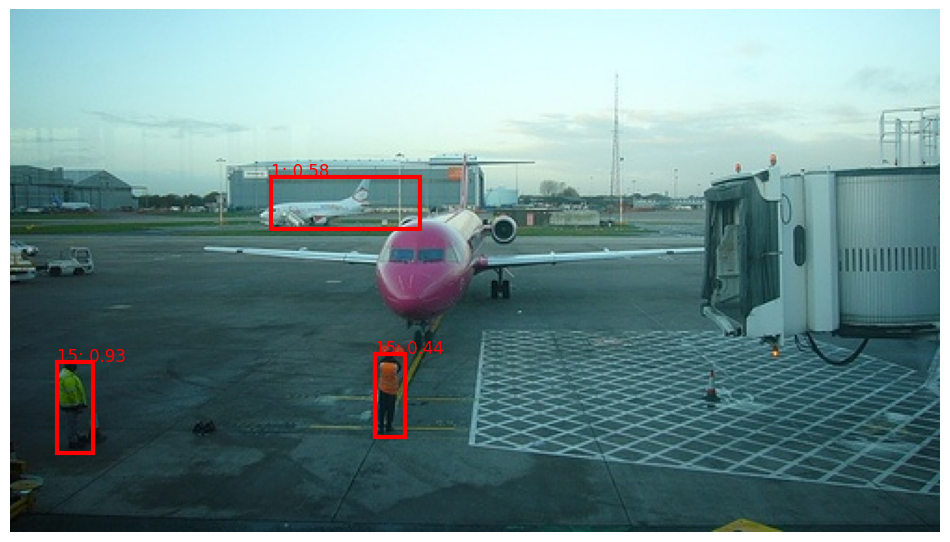

In [40]:
# Load a single image for inference
image_path = '/data_VOC/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg'  # Replace with your image path
image = load_image(image_path)

model.load_state_dict(torch.load('faster_rcnn_voc_best.pth', weights_only=True))

print(image)
# Prepare the model for inference
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    # Prepare the image
    input_image_ = prepare_image(image, transform)
    input_image = input_image_.to(device)

    # Run inference
    predictions = model(input_image)

# Extract boxes, labels, and scores from predictions
boxes = predictions[0]['boxes']
labels = predictions[0]['labels']
scores = predictions[0]['scores']

boxes = boxes.to('cpu')
labels = labels.to('cpu')
scores = scores.to('cpu')

print(boxes)
print(labels)
print(scores)

# Visualize the results
visualize_predictions(input_image_[0], boxes, labels, scores)


<PIL.Image.Image image mode=RGB size=500x366 at 0x7D5730081510>
tensor([[  0.0000, 104.6799, 497.7445, 248.0247],
        [ 50.1021,  74.8553, 334.2537, 327.9918],
        [124.8000,  77.7932, 490.4579, 312.8599],
        [253.0257, 254.5212, 314.7341, 360.1210],
        [328.3763, 188.4132, 415.4876, 221.5665],
        [418.7109, 201.5180, 479.3550, 222.4906],
        [256.4685, 256.5050, 328.9160, 358.9748],
        [269.6480, 269.2803, 325.7490, 349.3772],
        [139.8443, 104.4341, 498.5253, 336.5110],
        [109.0273, 244.8782, 231.2431, 361.8828],
        [357.0230, 219.6421, 459.4102, 353.2642],
        [251.0372, 312.6339, 492.0148, 366.0000],
        [219.9012, 282.0837, 489.3374, 359.8468],
        [319.2523, 220.9579, 497.1240, 315.1905],
        [254.0008, 238.6456, 326.9769, 360.1130],
        [  0.0000, 187.1453,  56.2749, 225.2569],
        [254.1028, 209.3189, 500.0000, 366.0000],
        [283.1857, 276.7450, 334.4638, 357.0576],
        [302.4171, 272.6073, 334.282

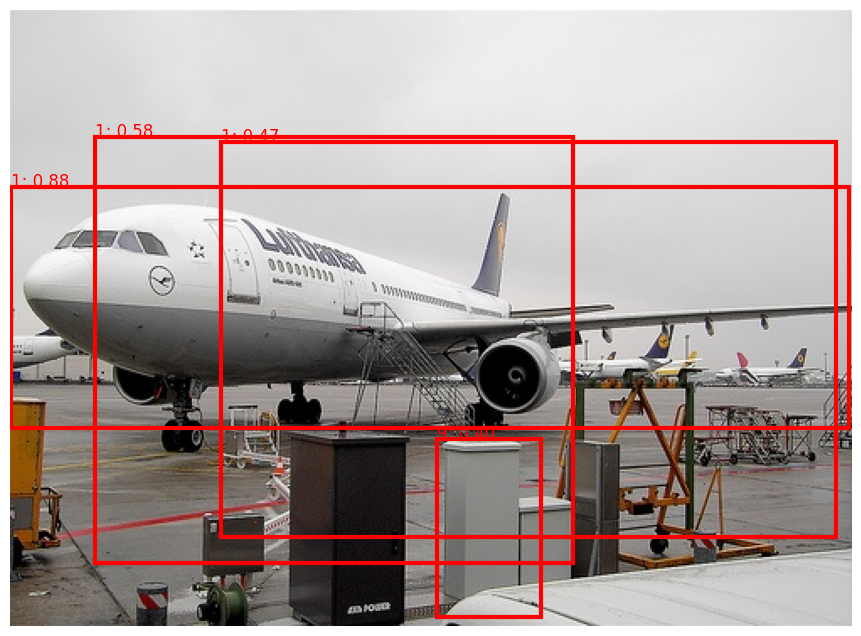

In [41]:
# Load a single image for inference
image_path = '/data_VOC/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg'  # Replace with your image path
image = load_image(image_path)

model.load_state_dict(torch.load('faster_rcnn_voc_best.pth', weights_only=True))

print(image)
# Prepare the model for inference
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    # Prepare the image
    input_image_ = prepare_image(image, transform)
    input_image = input_image_.to(device)

    # Run inference
    predictions = model(input_image)

# Extract boxes, labels, and scores from predictions
boxes = predictions[0]['boxes']
labels = predictions[0]['labels']
scores = predictions[0]['scores']

boxes = boxes.to('cpu')
labels = labels.to('cpu')
scores = scores.to('cpu')

print(boxes)
print(labels)
print(scores)

# Visualize the results
visualize_predictions(input_image_[0], boxes, labels, scores)


### Helper functions, to compute important metrics (IoU and mAP)

In [21]:
from typing import Counter
# Functions from https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master

def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculates intersection over union

    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct Labels of Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)

    Returns:
        tensor: Intersection over union for all examples
    """

    # Slicing idx:idx+1 in order to keep tensor dimensionality
    # Doing ... in indexing if there would be additional dimensions
    # Like for Yolo algorithm which would have (N, S, S, 4) in shape
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    elif box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # Need clamp(0) in case they do not intersect, then we want intersection to be 0
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="corners", num_classes=20
):
    """
    Calculates mean average precision

    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes

    Returns:
        float: mAP value across all classes given a specific IoU threshold
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

### Applying mAP to our validation set

In [22]:
def get_predictions_and_ground_truths(model, val_loader, device):
    model.eval()
    pred_boxes = []  # To store predictions
    true_boxes = []  # To store ground truths

    with torch.no_grad():
        for images, targets in val_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for i, output in enumerate(outputs):
                # Get the predicted boxes, scores, and labels
                pred_boxes_list = output['boxes'].cpu().numpy()
                pred_scores_list = output['scores'].cpu().numpy()
                pred_labels_list = output['labels'].cpu().numpy()

                # Filter out predictions with low scores
                for j in range(len(pred_boxes_list)):
                    if pred_scores_list[j] >= 0.05:  # Score threshold
                        pred_boxes.append([
                            i,  # image index
                            pred_labels_list[j],
                            pred_scores_list[j],
                            *pred_boxes_list[j]
                        ])

                # Get ground truth boxes and labels
                gt_boxes = targets[i]['boxes'].cpu().numpy()
                gt_labels = targets[i]['labels'].cpu().numpy()

                for k in range(len(gt_boxes)):
                    true_boxes.append([
                        i,  # image index
                        gt_labels[k],
                        1.0,  # Assuming ground truth boxes have a score of 1.0
                        *gt_boxes[k]
                    ])

    return pred_boxes, true_boxes

In [23]:
pred_boxes, true_boxes = get_predictions_and_ground_truths(model, val_loader, device)
mAP = mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5, box_format="corners", num_classes=num_classes)
print(f"Mean Average Precision (mAP): {mAP:.4f}")

Mean Average Precision (mAP): 0.5137


## Questions

1. Explore the dataset that you have at hand. Is there data imbalance ? What should you be wary of ?

We should be wary of overfitting, considering that we have a very small dataset compared to the size of the network.

There is a big data imbalance as objects of class 15 (person) are much more numerous than the others (31% of total), while classes 10 (cow) and 18 (sofa) are barely 2% of the total each (equidistribution should be 100/20=5%).

We must make sure that our random split does not overly factor "persons" objects (I've done it in a cell just below the training loop, i've found 50%+, not very good I guess) - this would lead the model to determine that guessing "person" every time is the best course of action. Such a random event would make the model overfit - it is mitigated by the fact that every image contains several objects


2. Fine-tune the architecture on the PASCAL-VOC dataset (or at least a subset of it, depending on the available ressources)

I divided the subset size by 2 because the calculations were too long and my computer was heating up badly


3. Adapt the training loop so that you get all the information necessary to draw the training curves (training / validation losses, eventually keeping track of a few metrics along the training). Add early stopping / adaptive learning rate.

Done, curve is below. With early stopping+ADAM, my training stops after only 3-4 epochs

4. Analyse your results. Does your model works ? What could you change to improve the performances of it ?

The model has a mAP close to 50%. While this is difficult to analyze (According to https://paperswithcode.com/sota/object-detection-on-pascal-voc-2012, this would put us in mid 2010s SotA, still a far cry from today's 90+mAP - but, it has to be said that we didn't train on the whole dataset


5. Modify the hyperparameters to improve the performances of your network.
6. Feel free to play with the architecture ! Try another backbone, another pretrained model...
7. Keep track of all your experiments, and report on them : what have you learned ?

Training losses after each epoch
[0.48973941 0.40342042 0.36280691]

Validation losses after each epoch
[0.43320033 0.35996847 0.39226353]


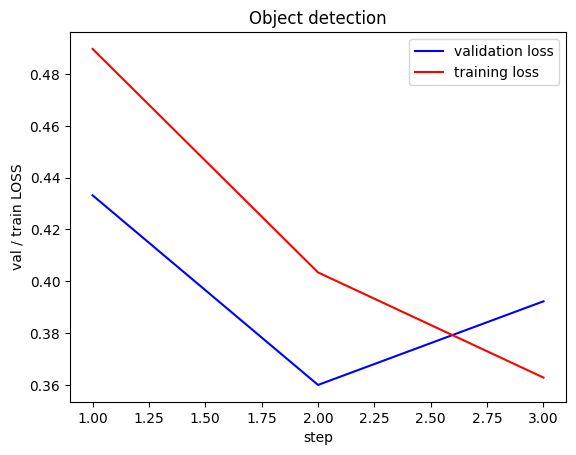

In [38]:
# Question 3: Curve

print("Training losses after each epoch")
print(train_loss_array)
print("")
print("Validation losses after each epoch")
print(val_loss_array)


plt.clf()
plt.xlabel('step')
plt.ylabel('val / train LOSS')
plt.title('Object detection')
# validation error in blue, train error in red
plt.plot(range(1,len(val_loss_array)+1), val_loss_array.tolist(), 'b', range(1,len(train_loss_array)+1), train_loss_array.tolist(), 'r')
plt.legend(['validation loss', 'training loss'])
plt.show()